# DU-GD法 (最小二乗問題)

周期性条件あり

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [1]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux

### 準備 (グローバル定数の設定)

In [2]:
n = 50
m = 100
num_itr = 50
K = 100
adam_lr = 1e-4
max_inner = 40 

A = randn(m,n)
Pinv = (A'*A)^(-1)*A'
eig = eigvals(A'*A)
λmin = minimum(eig)
λmax = maximum(eig)
ηopt = 2/(λmin + λmax)

0.006677074348431478

### ミニバッチ生成関数

In [3]:
function mini_batch(K)
    y = randn(m,K)
    x_opt = Pinv*y
    return y, x_opt
end

mini_batch (generic function with 1 method)

### 固定ステップサイズのGD法のMSE

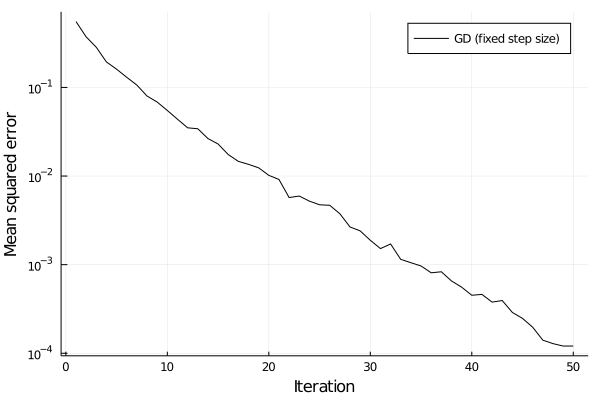

In [4]:
function GD(max_itr, y)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - ηopt*A'*(A*x - y)
    end
    return x
end

function comp_mse(max_itr)
    y, x_opt = mini_batch(K)
    x̂ = GD(max_itr, y)
    return norm(x_opt - x̂)^2/K
end
        
GD_mse = [comp_mse(i) for i in 1:num_itr]
plot(1:num_itr, GD_mse, lw=1, yscale=:log10, label="GD (fixed step size)", color=:black,  xlabel="Iteration", ylabel="Mean squared error")

### DU-GD反復の定義 

In [5]:
function DU_GD(max_itr, y, η, T)
    x = zeros(n, K)
    for i in 0:max_itr-1
        k = (i % T)+1
        x = x - η[k]*A'*(A*x - y)
    end
    return x
end

DU_GD (generic function with 1 method)

### 損失関数の定義

In [6]:
function loss(x_opt, x̂)
    return norm(x_opt - x̂)^2/K
end     

loss (generic function with 1 method)

### 訓練関数の定義

In [7]:
function train(opt, η, T)
    ps = params(η) 
    for itr in 1:num_itr
        for i in 1:max_inner
            y, x_opt = mini_batch(K)
            gs = gradient(ps) do
                x_est = DU_GD(itr, y, η, T)
                loss(x_opt, x_est)
            end
            Flux.Optimise.update!(opt, ps, gs)
        end
        y, x_opt = mini_batch(K)
        x_est = DU_GD(itr, y, η, T)
        println(itr, " ", loss(x_opt, x_est))
    end
end

train (generic function with 1 method)

### DU-GDのMSE評価用関数

In [8]:
function comp_mse_DUGD(max_itr, η, T)
    y, x_opt = mini_batch(K)
    x̂ = DU_GD(max_itr, y, η, T)
    return loss(x_opt, x̂)
end

comp_mse_DUGD (generic function with 1 method)

### 学習過程 $(T=2)$

1 0.6387729836236453
2 0.3956747123245193
3 0.2585796232527809
4 0.18624192782751414
5 0.16002679094661865
6 0.10565946632902116
7 0.08847925809801555
8 0.062000676662025064
9 0.038860497933416595
10 0.03144752352741431
11 0.024644274116011063
12 0.01607771259421549
13 0.011955474523000588
14 0.011706845851745005
15 0.008363690508736036
16 0.006393013647824447
17 0.004256593135894565
18 0.0032362091864771405
19 0.00274069383052506
20 0.001993842696729552
21 0.0011195457801580384
22 0.0012840311228007584
23 0.0009275596643180894
24 0.000916963408700386
25 0.0005416309058435446
26 0.00037102720650208134
27 0.00032636952404999813
28 0.00039700654839490673
29 0.0002450787955024194
30 0.0001994531292244905
31 0.00014286979837036255
32 0.00013901319631949647
33 8.778404469698475e-5
34 9.724443069712496e-5
35 6.057707230572394e-5
36 6.054981621589904e-5
37 4.434204184312074e-5
38 3.680587310713507e-5
39 2.1028558479679822e-5
40 2.073548778763315e-5
41 1.5703121937173258e-5
42 1.56049561791734

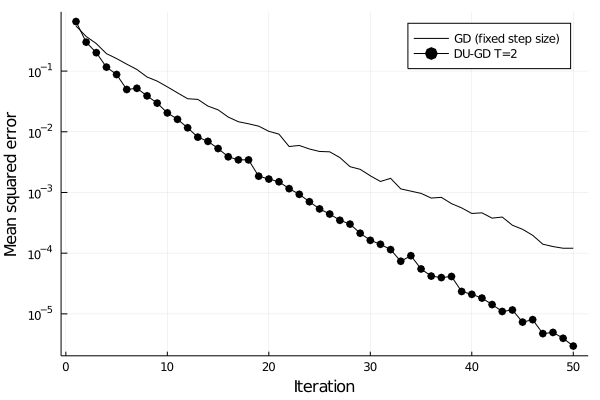

In [9]:
T = 2
η_train = zeros(T) 
opt = ADAM(adam_lr) 
@time train(opt, η_train, T)
DUGD_mse =[comp_mse_DUGD(i, η_train, T) for i in 1:num_itr]
opt_param1 = [η_train[(i%T)+1] for i in 0:num_itr-1]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-GD T="*string(T), color=:black, marker=:o)

### 学習過程 $(T=8)$

1 0.6817562041578432
2 0.3728572072611389
3 0.24934677166855945
4 0.15122553790859614
5 0.1102792637207265
6 0.07423275415977819
7 0.05116870603771493
8 0.039878896549548994
9 0.026451250939929158
10 0.011515824706777908
11 0.010359764435106146
12 0.009707054192947807
13 0.006244219313523384
14 0.004857448188161647
15 0.004036142802129147
16 0.0030484672825980635
17 0.0018932337642402234
18 0.0020072670866729493
19 0.0010668821825477372
20 0.0008667535669234189
21 0.0006150013609241735
22 0.00043472445955978074
23 0.00031478749605257377
24 0.00028316409593595794
25 0.0002540896524127736
26 0.00028242988976832114
27 0.00011831934587605088
28 0.00011066590900854602
29 7.122810932895734e-5
30 4.629990405769654e-5
31 4.4333553910715036e-5
32 4.462792533338391e-5
33 3.813121791847303e-5
34 2.2059497972822012e-5
35 1.696851600293436e-5
36 1.697040929368807e-5
37 9.696641280984498e-6
38 6.883753193240262e-6
39 7.633306694022432e-6
40 5.220922980408514e-6
41 4.874290452887106e-6
42 2.955363622

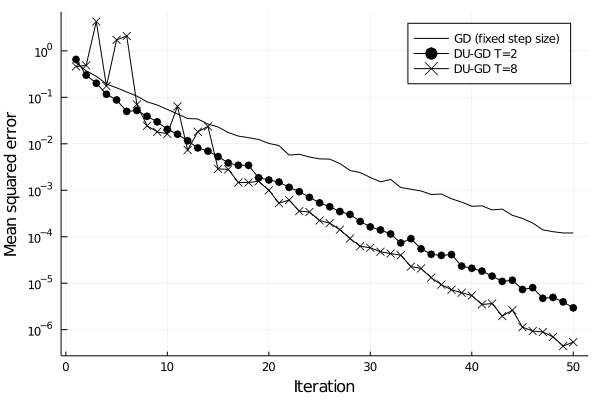

In [10]:
T = 8
η_train = zeros(T) 
opt = ADAM(adam_lr) 
train(opt, η_train, T)
DUGD_mse =[comp_mse_DUGD(i, η_train, T) for i in 1:num_itr]
opt_param2 = [η_train[(i%T)+1] for i in 0:num_itr-1]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-GD T="*string(T), color=:black, marker=:x)

In [11]:
savefig("DU-GD-LMS.pdf")

### 最適パラメータのプロット

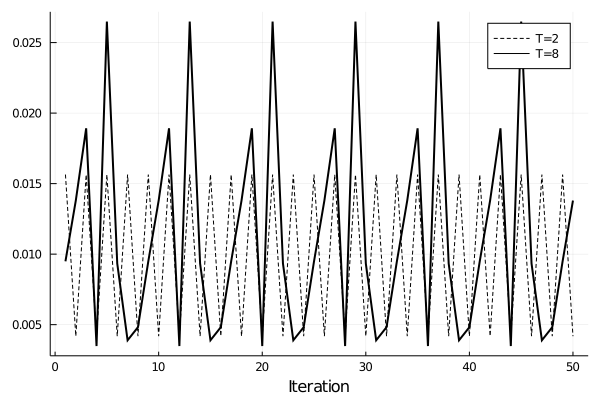

In [12]:
plot(1:num_itr, opt_param1, lw=1, label="T=2", color=:black, ls=:dash, xlabel="Iteration")
plot!(1:num_itr, opt_param2, lw=2, label="T=8", color=:black)

In [13]:
savefig("DU-GD-params.pdf")